# Colab commands

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/build_model/TrainValidate.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_features_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_labels_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_sources_removed.csv /content
!cp /content/drive/MyDrive/all_removed_weighted_sampler_full_epoch_1000_fold_2.pth /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_features_prices.csv /content
!mkdir /content/models

In [ ]:
!pip install --quiet torchinfo
!pip install --quiet torch_snippets

# Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

import torchinfo
from torch_snippets import Report
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from TrainValidate import TrainValidate, create_weighted_sampler

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"

/Users/luowx0905/opt/anaconda3/envs/ML_m1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

'mps'

# Build the model

In [3]:
class PredictStatus(nn.Module):
    def __init__(self, in_features):
        super(PredictStatus, self).__init__()

        self.hidden = nn.Sequential(nn.Linear(in_features, 256),
                                    nn.BatchNorm1d(256),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(256, 512),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(512, 1024),
                                    nn.BatchNorm1d(1024),
                                    nn.Dropout(0.8),
                                    nn.ReLU(),
                                    nn.Linear(1024, 256),
                                    nn.BatchNorm1d(256),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(256, 64),
                                    nn.BatchNorm1d(64),
                                    nn.Dropout(0.8),
                                    nn.ReLU())
        self.status = nn.Sequential(nn.Linear(64, 1),
                                    nn.Sigmoid())

    def forward(self, x):
        hidden = self.hidden(x)
        out = self.status(hidden)

        return out

# Class for collecting data

In [4]:
class StatusDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self.features = features
        self.labels = labels

    def __getitem__(self, item):
        features = self.features.to_numpy()[item]
        features = torch.tensor(features).float().to(device)

        labels = self.labels.to_numpy()[item]
        price = torch.tensor([labels[0]]).float().to(device)

        return features, price

    def __len__(self):
        return len(self.features)

# Basic model without prices

## Load datasets

In [5]:
features = pd.read_csv("../datasets/final_features_removed.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")

## Data standardization

In [6]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

## Split datasets

In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

In [8]:
temp = StatusDataset(x_train, y_train)
in_features = len(temp[0][0])
in_features

51

## Cross validation



-------------This is fold 0----------------
EPOCH: 100.000	val_loss: 0.634	(472.31s - 0.00s remaining)g))

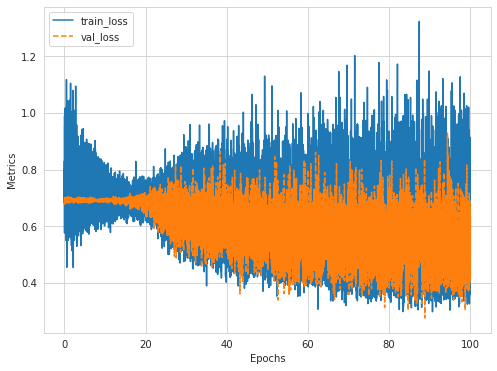



-------------This is fold 1----------------
EPOCH: 100.000	val_loss: 0.475	(605.56s - 0.00s remaining)g))

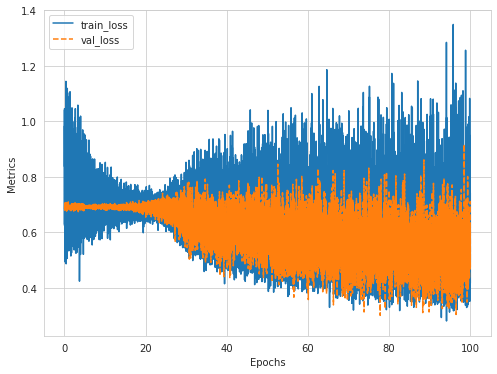



-------------This is fold 2----------------
EPOCH: 100.000	val_loss: 0.525	(710.79s - 0.00s remaining)g))

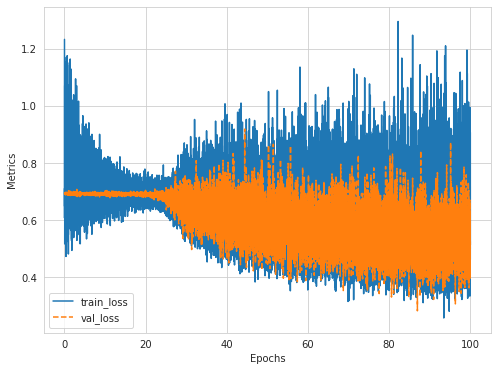



-------------This is fold 3----------------
EPOCH: 100.000	val_loss: 0.590	(719.53s - 0.00s remaining)g))

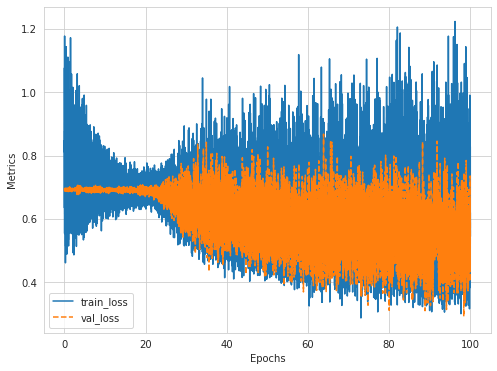



-------------This is fold 4----------------
EPOCH: 100.000	val_loss: 0.520	(737.14s - 0.00s remaining)g))

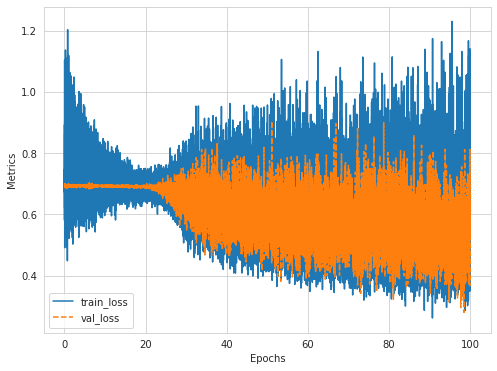

In [13]:
kfold = KFold(n_splits=5, shuffle=True)
epochs = 200

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatusDataset(train_feature, train_label)
    val_data = StatusDataset(val_feature, val_label)
    in_features = len(train_data[0][0])

    train_sampler = create_weighted_sampler(train_label["Completed"].values)
    val_sampler = create_weighted_sampler(val_label["Completed"].values)

    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True, sampler=val_sampler)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_validate = TrainValidate(model, nn.BCELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/status_exclude_fold_{}.pth".format(fold))

## Test performance

In [22]:
filename = "models/status_exclude_fold_4.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()
completed, labels = [], []
test_data = StatusDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, drop_last=False)

for data in test_loader:
    x, y = data
    x = x.to("cpu")
    y = y.to("cpu")

    pred_com = model(x)
    pred_com = torch.where(pred_com > 0.5, 1.0, 0.0)
    for item in pred_com.tolist():
        completed.append(item[0])
    for item in y.tolist():
        labels.append(item[0])

pred = pd.DataFrame({"pred_completed": completed, "Truth": labels})

[Text(0, 0.5, 'Completed'), Text(0, 1.5, 'Not Completed')]

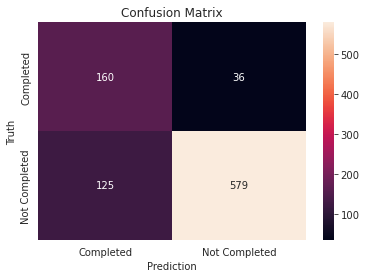

In [23]:
cm = confusion_matrix(pred["pred_completed"], pred["Truth"])
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Completed', 'Not Completed'])
ax.yaxis.set_ticklabels(['Completed', 'Not Completed'])

In [24]:
print("Accuracy: {}".format(accuracy_score(pred["pred_completed"], pred["Truth"])))
print("Recall: {}".format(recall_score(pred["pred_completed"], pred["Truth"])))
print("Precision: {}".format(precision_score(pred["pred_completed"], pred["Truth"])))
print("F1 Score: {}".format(f1_score(pred["pred_completed"], pred["Truth"])))

Accuracy: 0.8211111111111111
Recall: 0.8224431818181818
Precision: 0.9414634146341463
F1 Score: 0.8779378316906747


# Add bias
## Prepare data

In [ ]:
features = pd.read_csv("../datasets/final_features_removed.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")

scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

temp = StatusDataset(x_train, y_train)
in_features = len(temp[0][0])
in_features

## Train the model

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
epochs = 200

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatusDataset(train_feature, train_label)
    val_data = StatusDataset(val_feature, val_label)
    in_features = len(train_data[0][0])

    train_sampler = create_weighted_sampler(train_label["Completed"].values, [0.05, 0])
    val_sampler = create_weighted_sampler(val_label["Completed"].values, [0.05, 0])

    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True, sampler=val_sampler)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_validate = TrainValidate(model, nn.BCELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/status_exclude_bias_005_fold_{}.pth".format(fold))

## Test performance

[Text(0, 0.5, 'Completed'), Text(0, 1.5, 'Not Completed')]

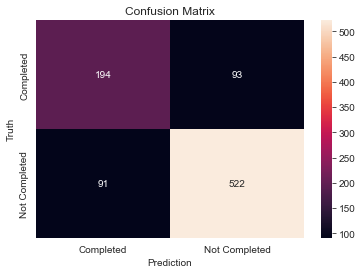

In [27]:
filename = "models/status_exclude_bias_015_fold_4.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()
completed, labels = [], []
test_data = StatusDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, drop_last=False)

for data in test_loader:
    x, y = data
    x = x.to("cpu")
    y = y.to("cpu")

    pred_com = model(x)
    pred_com = torch.where(pred_com > 0.5, 1.0, 0.0)
    for item in pred_com.tolist():
        completed.append(item[0])
    for item in y.tolist():
        labels.append(item[0])

pred = pd.DataFrame({"pred_completed": completed, "Truth": labels})

cm = confusion_matrix(pred["pred_completed"], pred["Truth"])
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Completed', 'Not Completed'])
ax.yaxis.set_ticklabels(['Completed', 'Not Completed'])

In [28]:
print("Accuracy: {}".format(accuracy_score(pred["pred_completed"], pred["Truth"])))
print("Recall: {}".format(recall_score(pred["pred_completed"], pred["Truth"])))
print("Precision: {}".format(precision_score(pred["pred_completed"], pred["Truth"])))
print("F1 Score: {}".format(f1_score(pred["pred_completed"], pred["Truth"])))

Accuracy: 0.7955555555555556
Recall: 0.8515497553017944
Precision: 0.848780487804878
F1 Score: 0.8501628664495114
